In [1]:
prom_file_path = "../r11n14_tb.parquet"

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras import regularizers

2023-08-18 15:22:04.312206: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 15:22:04.314809: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 15:22:04.362109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 15:22:04.363090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 15:22:05.124507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
import pandas as pd
prom_df = pd.read_parquet(prom_file_path)

In [4]:
feature_cols = [col for col in prom_df.columns if col not in ['node', 'timestamp', 'isAnomaly','node_netstat_Udp_InErrors','node_netstat_Tcp_InErrs','node_netstat_Icmp_InErrors','node_filesystem_device_error-sum']]
X = prom_df[feature_cols]
y = prom_df['isAnomaly']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X.shape[1]  
encoding_dim = 14  
batch_size = 32
epochs = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=['mae'])

history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_scaled, X_scaled))

Epoch 1/20
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3612 - mae: 0.4198 - val_loss: 0.3326 - val_mae: 0.3959
Epoch 2/20
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3321 - mae: 0.3934 - val_loss: 0.3317 - val_mae: 0.3918
Epoch 3/20
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3316 - mae: 0.3910 - val_loss: 0.3314 - val_mae: 0.3902
Epoch 4/20
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3313 - mae: 0.3897 - val_loss: 0.3312 - val_mae: 0.3889
Epoch 5/20
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3311 - mae: 0.3885 - val_loss: 0.3311 - val_mae: 0.3890
Epoch 6/20
1152/1152 [==============================] - 5s 4ms/step - loss: 0.3310 - mae: 0.3880 - val_loss: 0.3311 - val_mae: 0.3892
Epoch 7/20
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3310 - mae: 0.3879 - val_loss: 0.3310 - val_mae: 0.3874
Epoch 8/20
1152/1152 [==============================] - 5s 4ms

In [5]:
autoencoder.save('r11n14_autoencoder_model.h5')

In [6]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

1152/1152 [==============================] - 1s 923us/step
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     24560
           1       0.44      0.43      0.43     12286

    accuracy                           0.62     36846
   macro avg       0.58      0.58      0.58     36846
weighted avg       0.62      0.62      0.62     36846

[[17701  6859]
 [ 6986  5300]]


In [ ]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

   1/1152 [..............................] - ETA: 1:10

1152/1152 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24560
           1       0.98      0.97      0.98     12286

    accuracy                           0.98     36846
   macro avg       0.98      0.98      0.98     36846
weighted avg       0.98      0.98      0.98     36846

[[24319   241]
 [  368 11918]]


In [ ]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

   1/1152 [..............................] - ETA: 1:43

1152/1152 [==============================] - 1s 901us/step
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     24560
           1       0.43      0.43      0.43     12286

    accuracy                           0.62     36846
   macro avg       0.58      0.57      0.58     36846
weighted avg       0.62      0.62      0.62     36846

[[17682  6878]
 [ 7005  5281]]


In [8]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

  50/1152 [>.............................] - ETA: 2s

1152/1152 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     24560
           1       0.44      0.43      0.43     12286

    accuracy                           0.62     36846
   macro avg       0.58      0.58      0.58     36846
weighted avg       0.62      0.62      0.62     36846

[[17703  6857]
 [ 6984  5302]]


In [16]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

 110/1152 [=>............................] - ETA: 1s

1152/1152 [==============================] - 1s 859us/step
              precision    recall  f1-score   support

           0       0.72      0.73      0.73     24560
           1       0.45      0.44      0.45     12286

    accuracy                           0.63     36846
   macro avg       0.59      0.59      0.59     36846
weighted avg       0.63      0.63      0.63     36846

[[17855  6705]
 [ 6832  5454]]


In [17]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

1152/1152 [==============================] - 1s 792us/step
              precision    recall  f1-score   support

           0       0.72      0.73      0.73     24560
           1       0.45      0.44      0.45     12286

    accuracy                           0.63     36846
   macro avg       0.59      0.59      0.59     36846
weighted avg       0.63      0.63      0.63     36846

[[17855  6705]
 [ 6832  5454]]


In [20]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

1152/1152 [==============================] - 1s 991us/step
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     24560
           1       0.00      0.00      0.00     12286

    accuracy                           0.34     36846
   macro avg       0.25      0.25      0.25     36846
weighted avg       0.34      0.34      0.34     36846

[[12418 12142]
 [12269    17]]


In [26]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

   1/1152 [..............................] - ETA: 1:06

1152/1152 [==============================] - 1s 916us/step
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     24560
           1       0.00      0.00      0.00     12286

    accuracy                           0.34     36846
   macro avg       0.25      0.25      0.25     36846
weighted avg       0.34      0.34      0.34     36846

[[12418 12142]
 [12269    17]]


1152/1152 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     24560
           1       0.00      0.00      0.00     12286

    accuracy                           0.34     36846
   macro avg       0.25      0.25      0.25     36846
weighted avg       0.34      0.34      0.34     36846

Confusion matrix:
 [[12418 12142]
 [12269    17]]
ROC AUC Score: 0.2535012906297839


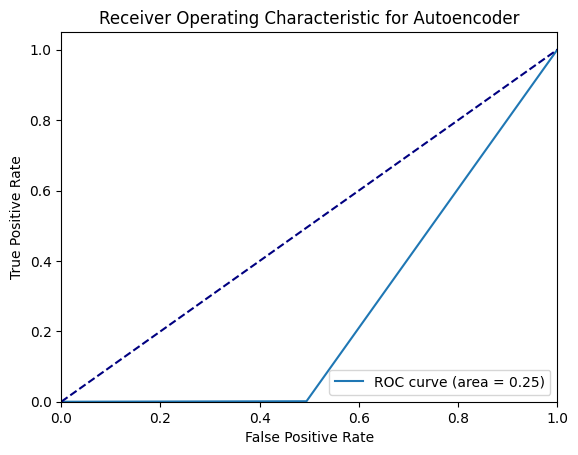

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)
threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]
print(classification_report(y, y_pred))

conf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(y, y_pred)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Autoencoder')
plt.legend(loc="lower right")

plt.savefig('autoencoder_roc_curve_r11n14.pdf', format='pdf')

plt.show()


1152/1152 [==============================] - 1s 841us/step
              precision    recall  f1-score   support

           0       0.72      0.73      0.73     24560
           1       0.45      0.44      0.45     12286

    accuracy                           0.63     36846
   macro avg       0.59      0.59      0.59     36846
weighted avg       0.63      0.63      0.63     36846

Confusion matrix:
 [[17855  6705]
 [ 6832  5454]]
ROC AUC Score: 0.585457511422922


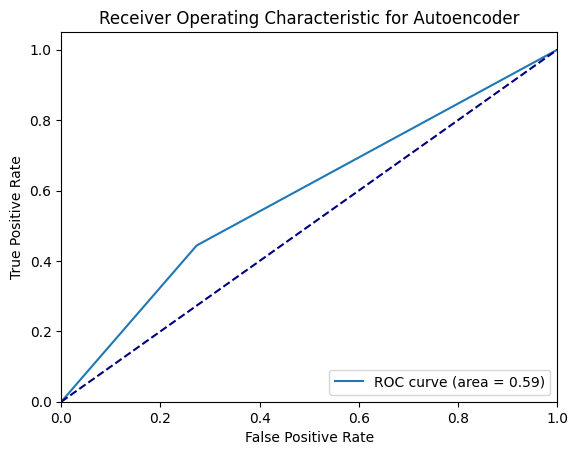

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)
threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]
print(classification_report(y, y_pred))

conf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(y, y_pred)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Autoencoder')
plt.legend(loc="lower right")

plt.savefig('autoencoder_roc_curve_r11n14.pdf', format='pdf')

plt.show()
